## A gente

- Lucas Emanuel
    - 3º período de Matemática Aplicada na FGV
- Vitoria
    - 5º período de Matemática Aplicada na FGV

## Jupyter

- Apresentações
    - Outputs
    - Markdown
        - $\LaTeX$
    - Fins didáticos
- Terminal
- Multilinguagem
    - Ótimo para Julia, Python e R
- Servidores na nuvem
    - JuliaBox
- Jupyter Lab
- Shortcuts
- GitHub

In [206]:
using Printf, Plots, StatPlots, DataFrames
using JuMP, Cbc

## Funções auxiliares

In [207]:
function capacidade(X, G)
    capacidade = zeros(12)
    for i in 1:12
        for j in 1:length(G)
            if round(Int, X[j, i])==1
                capacidade[i]+=G[j]
            end
        end
    end
    c = sum(G)
    for i in 1:12
        capacidade[i] = c-capacidade[i]
    end
    return capacidade
end

capacidade (generic function with 1 method)

In [208]:
function cvar(θ, S, Dl)
    CVaR = zeros(12)
    VaR = ceil(Int, θ*S)
    for i in 1:12
        CVaR[i] = sum(sort(Dl[i, S-VaR+1:end]))/(VaR)
    end
    return CVaR
end

cvar (generic function with 1 method)

In [209]:
function dados_e_plot(G, schedule_matrix, d; title = "", alpha = 0.4, CVaR = zeros(1:12), legend = false)
    if length(size(G)) == 1
        nplants = length(G)
    else
        nplants = size(G)[1]
    end
    if length(size(d)) == 1
        nmonths = length(d)
    else
        nmonths = size(d)[1]
        Ns = size(d)[2]
    end
    schedule = DataFrame(months = collect(1:nmonths), plants_off = [[] for i in 1:nmonths],
        capacity_available = collect(zeros(1:nmonths)))
    for plant in 1:nplants
        for month in 1:nmonths
            if round(schedule_matrix[plant, month] - 0.1) == 1.0
                push!(schedule.plants_off[month], plant)
            else
                if length(size(G)) == 1
                    schedule.capacity_available[month] += G[plant] 
                else
                    schedule.capacity_available[month] += G[plant, month]
                end
            end
        end
    end
    plot1 = heatmap(schedule_matrix, colorbar = false, xlabel = "Meses", ylabel = "Usinas", xaxis = collect(1:nmonths),
        yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1, title = "Heatmap das manutenções")
    #plot1 = bar(collect(1:nmonths), [size(plants_off) for plants_off in schedule.plants_off], xlabel = "Months", ylabel = "Number of plants off", aspect_ratio = 1, xaxis = collect(1:nmonths), yaxis = collect(1:nplants), color = :redsblues)
    if length(size(d)) == 1
        return schedule, plot1, groupedbar([schedule.capacity_available d], title = title, label = ["Capacidade", "Demanda"],
            legend = legend, xaxis = collect(1:nmonths), xlabel = "Meses", ylabel = "Energia", ylims = (0,350))
    else
        if sum(CVaR) == 0
            plot2 = groupedbar([schedule.capacity_available [maximum(d[month, :]) for month in 1:nmonths] [sum(d[month, :]) / Ns for month in 1:nmonths]],
                title = title, label = ["Capacidade", "Maior demanda", "Valor esp. da demanda"],
                legend = legend, xaxis = collect(1:nmonths), xlabel = "Mês", ylabel = "Energia", ylims = (0, 350))
        else
            plot2 = groupedbar([schedule.capacity_available [maximum(d[month, :]) for month in 1:nmonths] CVaR],
                title = title, label = ["Capacidade", "Maior demanda", "CVaR"],
                legend = legend, xaxis = collect(1:nmonths), xlabel = "Mês", ylabel = "Energia", ylims = (0, 350))
        end
        return schedule, plot1, plot2
    end
end;

In [210]:
function comparison(d, G, dados1, schedule_matrix1, dados2, schedule_matrix2; xlabel1 = "dados1", xlabel2 = "dados2",
        title = "Comparação da capacidade disponível", legend1 = false)
    nplants = length(G)
    nmonths = size(dados1, 1)
    Ns = size(d)[2]
    plot1 = groupedbar([dados1.capacity_available dados2.capacity_available [maximum(d[month, :]) for month in 1:nmonths] [sum(d[month, :]) / Ns for month in 1:nmonths]],
        label = [xlabel1; xlabel2; ["Maior demanda"]; ["Valor esp. da demanda"]],
        xlabel = "Mês", ylabel = "Capacidade", xaxis = collect(1:nmonths), title = title, legend = legend1, ylims = (0, 350))
    plot2 = bar(collect(1:nmonths), [size(dados1.plants_off[month])[1] for month in 1:nmonths], xaxis = collect(1:nmonths),
        ylabel = "Nº de usinas desligadas", xlabel = xlabel1, legend = false)
    plot3 = bar(collect(1:nmonths), [size(dados2.plants_off[month])[1] for month in 1:nmonths], xaxis = collect(1:nmonths),
        xlabel = xlabel2, legend = false)
    plot4 = heatmap(schedule_matrix1, colorbar = false, xlabel = "Meses", ylabel = "Usinas", xaxis = collect(1:nmonths),
        yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1)
    plot5 = heatmap(schedule_matrix2, colorbar = false, xlabel = "Meses", xaxis = collect(1:nmonths),
        yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1)    
    plot6 = plot(plot2, plot3, plot4, plot5, layout = (2, 2), link = :y)
    return plot1, plot6
end;

# Problema de agendamento de manutenção

In [211]:
# Capacidade de cada usina
G = [10,5,20,18,23,32,7,12,10,20,17,32,12,13,17];
# Demanda de cada mês
D = [238,220,187,175,135,127,144,165,193,205,213,233];
#θ piores casos
θ = 0.2
#Número de cenários
Ns = 10;

## 1) Problema inicial

<center>$min$ $\alpha$</center>

<center>$s.a.$ $\alpha$ $\geq$ $\sum_i Gdisp_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [212]:
function modelo1(G, d)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α);
    @objective(m, Min, α);
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
      myCons1[j] = @constraint(m, α >= sum(G[i]*(1-x[i,j]) for i=1:N) - d[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
      myCons2[j] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= d[j])
    end
    @time status = solve(m)
    return m, getvalue(x)
end

modelo1 (generic function with 1 method)

In [213]:
m1, X1 = modelo1(G, D);

  0.249900 seconds (66 allocations: 64.070 KiB)


In [214]:
dados1, heatmap1, graph1 = dados_e_plot(G, X1, D, legend = true)
dados1

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[9],238.0
2,2,"[4, 9]",220.0
3,3,"[4, 5, 10]",187.0
4,4,"[2, 4, 5, 9, 11]",175.0
5,5,"[1, 4, 6, 7, 8, 11, 15]",135.0
6,6,"[2, 4, 6, 11, 12, 15]",127.0
7,7,"[2, 3, 5, 6, 7, 11]",144.0
8,8,"[8, 9, 11, 12, 13]",165.0
9,9,"[1, 10, 13, 14]",193.0


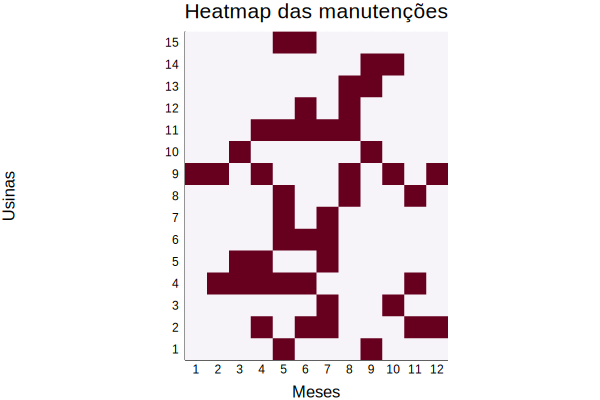

In [215]:
heatmap1

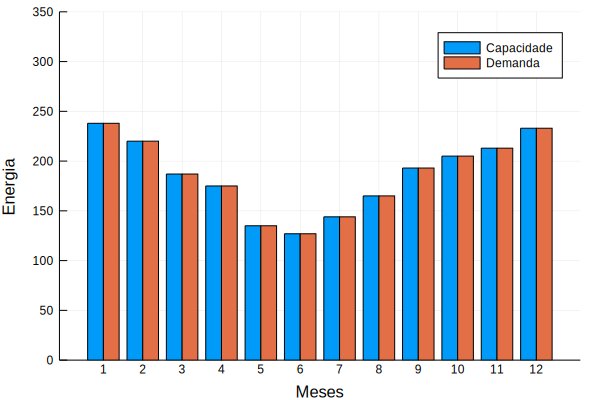

In [216]:
graph1

## 2) Cenários de renováveis e demanda líquida com otimização de valor esperado

<center>$min$ $\sum_s \alpha_t^s\cdot \frac{1}{N_s}$</center>

<center>$\alpha_t^s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [217]:
#Quantidade de cenários
S = 10;
#Capacidade de renováveis
R = rand(1:100,12, S);
Dl = D;
for i in 2:S
    Dl = hcat(Dl, D)
end
#Demanda líquida
Dl = Dl-R;

In [218]:
function modelo2(G, Dl)
    T = 12;
    N = length(G);
    S = size(Dl)[2];
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:S])
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons1[j,k] = @constraint(m, α[k] >= sum(G[i]*(1-x[i,j]) for i=1:N) - Dl[j,k])
        end
    end
    @constraintref myCons2[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons2[j,k] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= Dl[j,k])
        end
    end
    @objective(m, Min, sum(α[k] for k=1:S)/S);
    @time status = solve(m)
    return m, getvalue(x)
end

modelo2 (generic function with 1 method)

In [219]:
m2, X2 = modelo2(G, Dl);

  0.312374 seconds (71 allocations: 280.023 KiB)


In [220]:
dados2, heatmap2, graph2 = dados_e_plot(G, X2, Dl, legend = true)
dados2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[1, 2]",233.0
2,2,"[1, 7, 9, 13]",209.0
3,3,"[4, 5, 10]",187.0
4,4,"[2, 4, 7, 8, 9, 11, 13]",167.0
5,5,"[2, 4, 6, 7, 8, 9, 11, 13, 14]",122.0
6,6,"[2, 4, 5, 6, 11, 14, 15]",123.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[5, 6, 7, 8, 13]",162.0
9,9,"[8, 10, 13, 14]",191.0


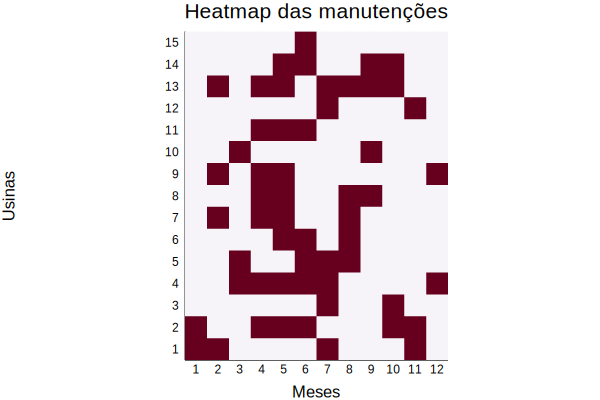

In [221]:
heatmap2

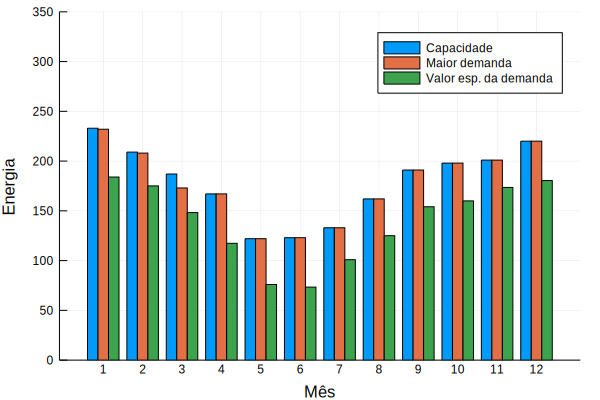

In [222]:
graph2

## 3) CVaR determinístico nas restrições

<center>$min$ $\alpha$</center>

<center>$\alpha$ $\geq$ $\sum_i Gdisp_i^t-CVaR_\theta(Dliq_t^s)$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [223]:
G3 = G
θ3 = θ
Ns3 = Ns
d3 = Dl
nCVaR3 = Int(floor(θ3 * Ns3))
nplants3 = length(G3)
nmonths3 = size(d3)[1];

In [224]:
CVaR_d3 = zeros(nmonths3)
for month in 1:nmonths3
    CVaR_d3[month] = sum(sort(d3[month, :])[(Ns3 - nCVaR3 + 1):Ns3]) / nCVaR3
end

In [225]:
m3 = Model(solver = CbcSolver())

@variable(m3, x[1:nplants3, 1:nmonths3], Bin)
@variable(m3, α)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m3, sum(x[plant, 1:nmonths3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths3, 1:Ns3]
for month in 1:nmonths3
    for scenario in 1:Ns3
        constraints2[month, scenario] = @constraint(m3, sum(G3 .* (1 .- x[1:nplants3, month])) >= d3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths3]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m3, α >= sum(G3 .* (1 .- x[1:nplants3, month])) - CVaR_d3[month])
end

@objective(m3, Min, α);

In [226]:
@time solve(m3)
schedule_matrix3 = getvalue(x);

  0.052858 seconds (75 allocations: 168.992 KiB)


In [227]:
dados3, heatmap3, graph3 = dados_e_plot(G3, schedule_matrix3, d3, CVaR = CVaR_d3, legend = true, alpha = 0.3)
dados3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[8],236.0
2,2,"[1, 9, 13]",216.0
3,3,"[4, 5, 6]",175.0
4,4,"[1, 5, 7, 8, 11, 13]",167.0
5,5,"[1, 2, 4, 7, 8, 9, 10, 11, 13, 14]",124.0
6,6,"[4, 7, 10, 11, 12, 14, 15]",124.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[5, 12, 13, 14]",168.0
9,9,"[8, 10, 13]",204.0


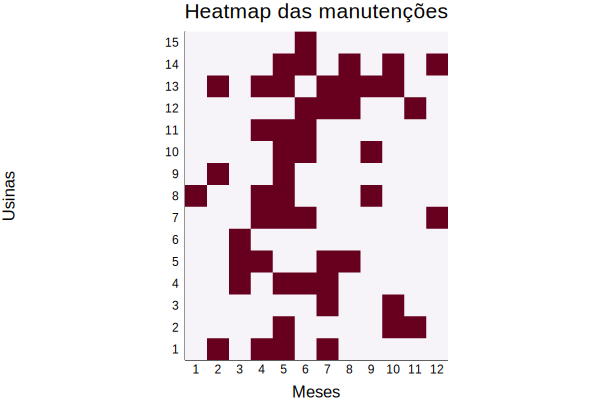

In [228]:
heatmap3

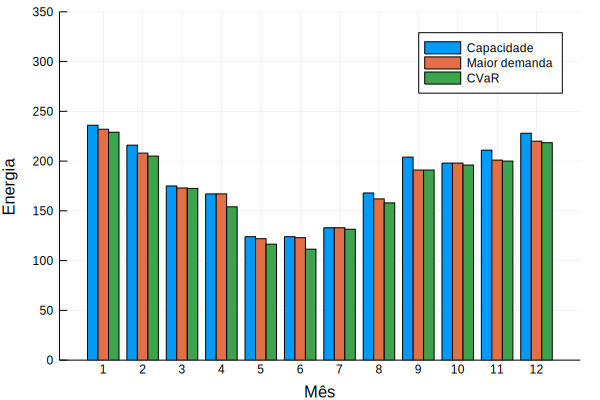

In [229]:
graph3

## 4) CVaR como problema de otimização na função objetivo

<center>$min$ $CVaR_\theta(\alpha)$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $C$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

In [230]:
G4 = G
d4 = Dl
θ4 = θ

Ns4 = Ns
nplants4 = length(G4)
nmonths4 = size(d4)[1];

In [231]:
m4 = Model(solver = CbcSolver())

@variable(m4, x[1:nplants4, 1:nmonths4], Bin)
@variable(m4, α[1:Ns4])
@variable(m4, z)
@variable(m4, δ[1:Ns4])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m4, sum(x[plant, 1:nmonths4]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths4, 1:Ns4]
for month in 1:nmonths4
    for scenario in 1:Ns4
        constraints2[month, scenario] = @constraint(m4, sum(G4 .* (1 .- x[1:nplants4, month])) >= d4[month, scenario])
    end
end

@constraintref constraints3[1:nmonths4, 1:Ns4]
for month in 1:nmonths4
    for scenario in 1:Ns4
        constraints3[month, scenario] = @constraint(m4,
            α[scenario] >= sum(G4 .* (1 .- x[1:nplants4, month])) - d4[month, scenario])
    end
end

@constraintref constraints4[1:Ns4]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m4, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns4]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m4, δ[scenario] <= 0)
end

@objective(m4, Min, z - sum(1 / Ns4 * δ[scenario] / (1 - θ4) for scenario in 1:Ns4));

In [232]:
@time solve(m4)
schedule_matrix4 = getvalue(x);

  0.189033 seconds (75 allocations: 285.555 KiB)


In [233]:
dados4, heatmap4, graph4 = dados_e_plot(G4, schedule_matrix4, d4, legend = true)
dados4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[1, 2]",233.0
2,2,"[1, 2, 9, 13]",211.0
3,3,"[4, 5, 10]",187.0
4,4,"[2, 5, 7, 11, 13, 15]",167.0
5,5,"[1, 4, 7, 8, 10, 11, 13, 14, 15]",122.0
6,6,"[2, 6, 9, 11, 12, 13, 15]",123.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[4, 6, 7, 13, 15]",162.0
9,9,"[2, 4, 8, 10]",193.0


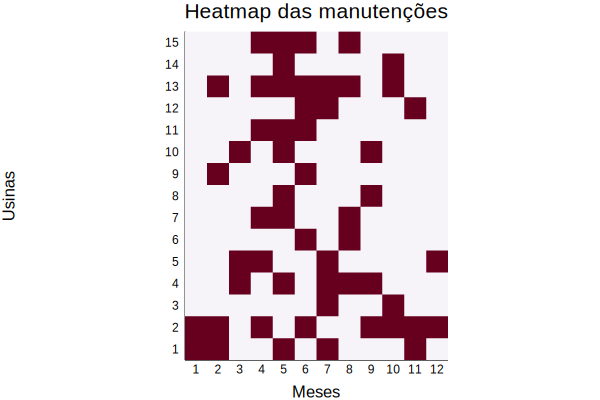

In [234]:
heatmap4

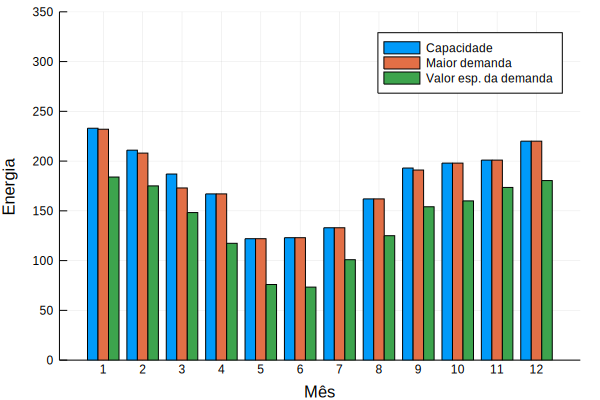

In [235]:
graph4

## Comparação entre o CVaR na função objetivo e na restrição

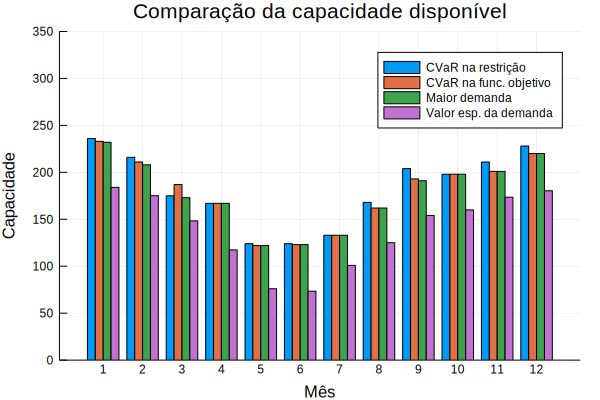

In [236]:
comp3and4 = comparison(Dl, G, dados3, schedule_matrix3, dados4, schedule_matrix4, xlabel1 = "CVaR na restrição", xlabel2 = "CVaR na func. objetivo", legend1 = true)
comp3and4[1]

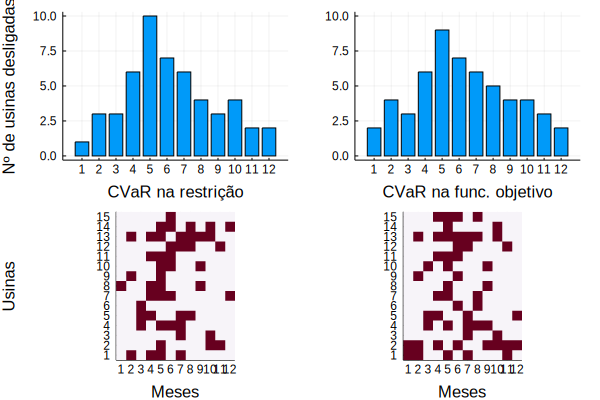

In [237]:
comp3and4[2]

## Comparação entre o CVaR e o valor esperado na função objetivo

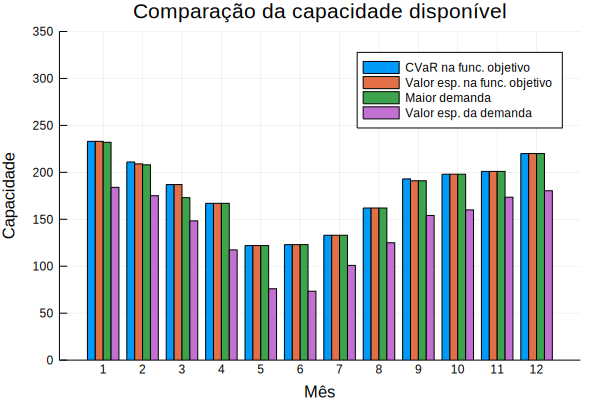

In [238]:
comp4and2 = comparison(Dl, G, dados4, schedule_matrix4, dados2, X2; xlabel1 = "CVaR na func. objetivo",
    xlabel2 = "Valor esp. na func. objetivo",
    legend1 = true)
comp4and2[1]

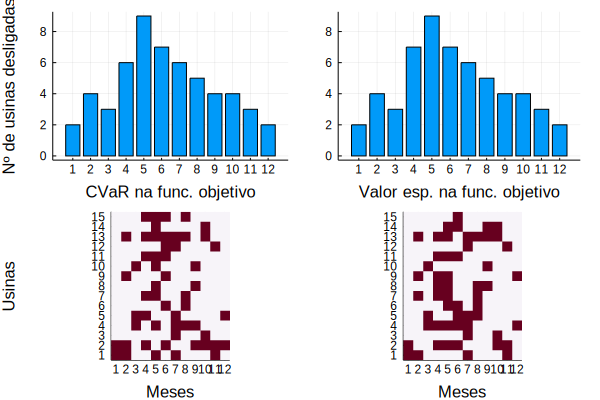

In [239]:
comp4and2[2]

## 5) Combinação convexa de valor esperado e CVaR

<center>$min$ $\lambda \cdot CVaR_\theta(\alpha) + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $\lambda \cdot C + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

In [240]:
G5 = G
d5 = Dl
θ5 = θ
λ5 = 0.5

Ns5 = Ns
nplants5 = length(G5)
nmonths5 = size(d5)[1];

In [241]:
m5 = Model(solver = CbcSolver())

@variable(m5, x[1:nplants5, 1:nmonths5], Bin)
@variable(m5, α[1:Ns5])
@variable(m5, z)
@variable(m5, δ[1:Ns5])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5, sum(x[plant, 1:nmonths5]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints2[month, scenario] = @constraint(m5, sum(G5 .* (1 .- x[1:nplants5, month])) >= d5[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints3[month, scenario] = @constraint(m5, α[scenario] >= sum(G5 .* (1 .- x[1:nplants5, month])) - d5[month, scenario])
    end
end

@constraintref constraints4[1:Ns5]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m5, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns5]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m5, δ[scenario] <= 0)
end

@expression(m5, CVaR, z - sum(1 / Ns5 * δ[scenario] / (1 - θ5) for scenario in 1:Ns5))
@expression(m5, Eα, sum(α) / Ns5)

@objective(m5, Min, λ5 * CVaR + (1 - λ5) * Eα);

In [242]:
@time solve(m5)
schedule_matrix5 = getvalue(x);

  0.128884 seconds (75 allocations: 285.555 KiB, 9.31% gc time)


In [243]:
dados5, heatmap5, graph5 = dados_e_plot(G5, schedule_matrix5, d5, legend = true)
dados5

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[1, 2]",233.0
2,2,"[1, 2, 9, 13]",211.0
3,3,"[4, 5, 10]",187.0
4,4,"[4, 6, 7, 8, 13]",167.0
5,5,"[4, 7, 8, 9, 10, 11, 13, 14, 15]",122.0
6,6,"[4, 6, 7, 8, 9, 11, 13, 15]",123.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[2, 6, 8, 10, 15]",162.0
9,9,"[2, 7, 8, 10, 13]",192.0


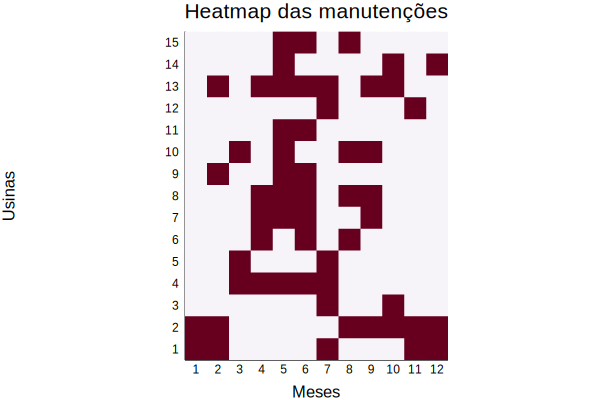

In [244]:
heatmap5

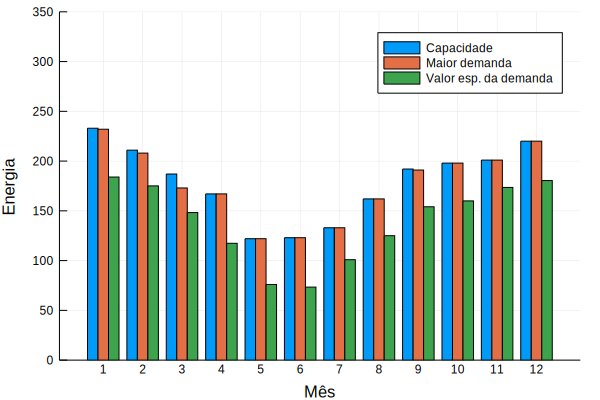

In [245]:
graph5

## 6) Minimizar custo total

<center>$min$ $\sum_t \alpha^t + \sum_{i,t}c_i\cdot g_i^t + \sum_{i,t} k_i \cdot x_i^t$</center>

<center>$\alpha^t$ $\geq$ $\sum_i g_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i g_i^t \geq D_t$ $\forall t$</center>

<center>$g_i^t \leq G_i\cdot (1-x_i^t)$</center>

In [246]:
# Custo de geração
c = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15];
# Custo de manutenção
k = [1,1,1,1,1,1,1,1,1,2,2,2,2,1,1];

In [247]:
function modelo6(G, D, c, k)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:T])
    @variable(m, g[1:N,1:T] >= 0)
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
        myCons1[j] = @constraint(m, α[j] >= sum(g[i,j] for i=1:N) - D[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
        myCons2[j] = @constraint(m, sum(g[i,j] for i=1:N) >= D[j])
    end
    @constraintref myCons3[1:N,1:T]
    for i = 1:N
        for j = 1:T
            myCons3[i,j] = @constraint(m, g[i,j]<=G[i]*(1-x[i,j]))
        end
    end
    @objective(m, Min, sum(α[j] for j=1:T)+sum(sum(c[i]*g[i,j] for i=1:N) for j=1:T)+sum(sum(k[i]*x[i,j] 
                for j=1:T) for i=1:N));
    @time status = solve(m)
    αa = getvalue(α)
    ga = getvalue(g)
    xa = getvalue(x)
    custo = [αa[j]+sum(c[i]*ga[i,j] for i=1:N)+sum(k[i]*xa[i,j] for i=1:N) for j = 1:T]
    return m, ga, xa, custo
end

modelo6 (generic function with 1 method)

In [248]:
m6, g6, X6, custo = modelo6(G,D,c,k);

  0.127558 seconds (66 allocations: 111.758 KiB)


In [249]:
cap = convert(DataFrame, g6)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0
2,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,20.0,20.0,20.0,20.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0
4,18.0,18.0,18.0,18.0,18.0,0.0,18.0,18.0,18.0,18.0,18.0,18.0
5,23.0,23.0,23.0,23.0,23.0,23.0,0.0,23.0,23.0,23.0,23.0,23.0
6,32.0,32.0,32.0,32.0,0.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
7,7.0,7.0,7.0,7.0,7.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0
8,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.0,12.0,12.0,12.0
9,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [254]:
dados6, heatmap6, graph6 = dados_e_plot(g6, X6, D, legend = true)
dados6

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],238.0
2,2,[],220.0
3,3,[],187.0
4,4,[10],175.0
5,5,"[6, 9, 13]",135.0
6,6,"[2, 3, 4, 11, 14]",127.0
7,7,"[5, 7, 12]",144.0
8,8,[1],165.0
9,9,[8],193.0


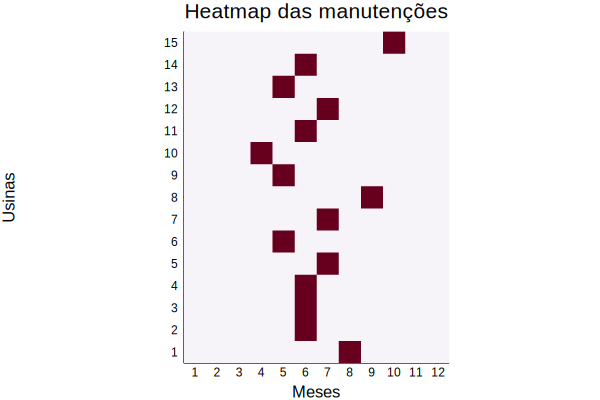

In [255]:
heatmap6

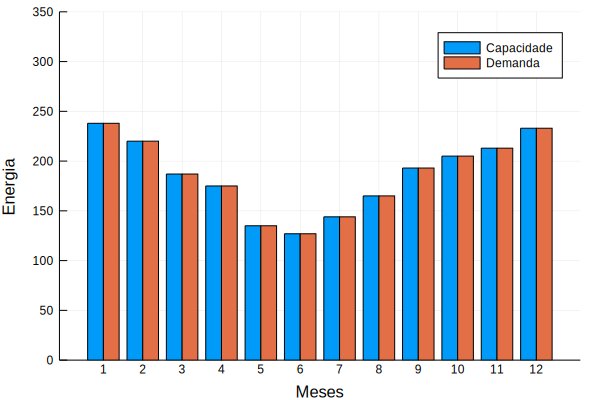

In [256]:
graph6

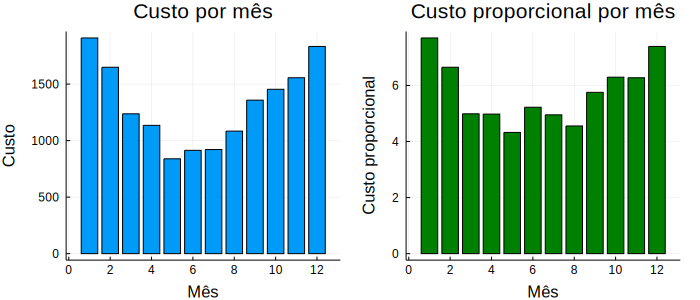

In [257]:
custo_mensal = bar(custo, legend=false, title = "Custo por mês", xlabel="Mês", ylabel="Custo")
cp = [custo[i]/capacidade6[i] for i in 1:12]
custo_proporcional = bar(cp, legend=false, title = "Custo proporcional por mês", xlabel="Mês", ylabel="Custo proporcional",
    color="green")
plot(custo_mensal, custo_proporcional, size=(700, 300))